In [2]:
from konlpy.tag import Okt
import re
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM

In [ ]:
def preprocessing(sentence, remove_stopwords=True):
    okt = Okt()
    # 불용어 리스트 정의 (현재는 빈 리스트로 설정)
    stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []

    # 개행문자 제거
    sentence = re.sub('\\\\n', ' ', sentence)

    # 한글 외의 모든 문자 제거
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '', sentence)

    # 형태소 분석 및 어간 추출
    sentence = okt.morphs(sentence, stem=True)

    # 불용어 제거 옵션이 True인 경우, 불용어 리스트에 포함되지 않은 토큰만 선택
    if remove_stopwords:
        sentence = [token for token in sentence if not token in stop_words]

    # 전처리된 문장 반환
    return sentence

In [3]:

# 불용어 리스트
stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
remove_stopwords=True

# train TSV 파일 읽기
with open("review.sorted.uniq.refined.tok.shuf.train.tsv", 'r') as f:
    lines = f.readlines()

# 데이터를 저장할 리스트 초기화
train_X = []
train_y = []

# 각 줄을 처리
for line in lines:
    # 탭(\t)으로 구분
    split_line = line.strip().split('\t')
    
    # 첫 번째 열: 레이블 처리
    if split_line[0].lower() == 'positive':
        train_y.append(1)
    elif split_line[0].lower() == 'negative':
        train_y.append(0)
    else:
        raise ValueError(f"Unknown label: {split_line[0]}")
    # okt를 통한 분리와 불용어 처리
    if remove_stopwords:
        x = [token for token in okt.morphs(split_line[1], stem=True) if not token in stop_words]
    train_X.append(x)

KeyboardInterrupt: 

In [3]:
# test TSV 파일 읽기
with open("review.sorted.uniq.refined.tok.shuf.test.tsv", 'r') as f:
    lines = f.readlines()

# 데이터를 저장할 리스트 초기화
test_X = []
test_y = []

# 각 줄을 처리
for line in lines:
    # 탭(\t)으로 구분
    split_line = line.strip().split('\t')
    
    # 첫 번째 열: 레이블 처리
    if split_line[0].lower() == 'positive':
        test_y.append(1)
    elif split_line[0].lower() == 'negative':
        test_y.append(0)
    else:
        raise ValueError(f"Unknown label: {split_line[0]}")
    # okt를 통한 분리와 불용어 처리
    if remove_stopwords:
        x = [token for token in okt.morphs(split_line[1], stem=True) if not token in stop_words]
    test_X.append(x)


In [28]:
pos=0
neg=0
for i in train_y:
    if(i==1):
        pos = pos+1
    else:
        neg = neg+1
print(pos)
print(neg)

82914
64979


In [29]:
pos=0
neg=0
for i in test_y:
    if(i==1):
        pos = pos+1
    else:
        neg = neg+1
print(pos)
print(neg)

16874
13126


In [ ]:
for i in range(0, 20):
    print(train_X[i])

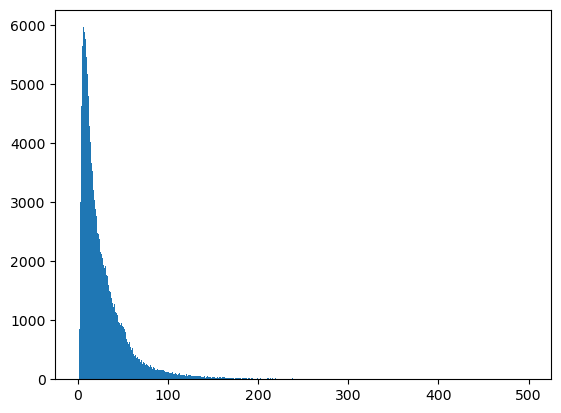

In [6]:
import matplotlib.pyplot as plt

# 리뷰 데이터 길이 시각화, 칸수 1000, 최대 1000개 길이까지만 시각화
plt.hist([len(s) for s in train_X], bins=500, range = [0, 500]);

패딩은 200 까지만 하는것이 효율적으로 보인다

In [7]:
# 모든 단어를 하나의 리스트로 합침
all_words = [word for sentence in train_X for word in sentence]

# 중복을 제거하여 단어 종류만 구하기
unique_words = set(all_words)

# 단어의 종류 개수
num_unique_words = len(unique_words)

print(f"단어의 종류는 총 {num_unique_words}개입니다.")

단어의 종류는 총 30227개입니다.


In [4]:
VOCAB_SIZE = 20000  # 어휘 크기
MAX_LENGTH = 100    # 최대 길이 100으로 제한

# 문장으로 부터 상위 40000 개 단어로 vocabulary 작성
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
# sentences에 포함된 문장들을 기반으로 단어의 토큰화를
# 수행하며, 각 단어에 고유한 인덱스를 할당
tokenizer.fit_on_texts(train_X)

# sentences 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(train_X)

# 시퀀스에 패딩 적용 (문장의 뒤쪽을 패딩하고, 필요시 뒤쪽을 잘라냄)
padded_train_X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# train 데이터를 통한 기록으로 test 데이터 전처리
# sentences 데이터를 시퀀스로 변환 (test 데이터)
sequences = tokenizer.texts_to_sequences(test_X)

# 시퀀스에 패딩 적용 (문장의 뒤쪽을 패딩하고, 필요시 뒤쪽을 잘라냄)
padded_test_X = pad_sequences(sequences,  maxlen=MAX_LENGTH, padding='post', truncating='post')

## 임베딩 레이어 적용

In [5]:
EMBEDDING_DIM = 128  # 임베딩 벡터의 차원

# Keras의 Embedding 레이어 초기화
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH)

# 임베딩 벡터 생성 (훈련 데이터)
embedded_train_X = embedding_layer(np.array(padded_train_X))

# 임베딩 벡터 생성 (테스트 데이터)
embedded_test_X = embedding_layer(np.array(padded_test_X))

embedded_train_X_avg = np.mean(embedded_train_X, axis=1)  # (샘플 수, EMBEDDING_DIM)
embedded_test_X_avg = np.mean(embedded_test_X, axis=1)    # (샘플 수, EMBEDDING_DIM)

print("Average Embedded Train Shape:", embedded_train_X_avg.shape)
print("Average Embedded Test Shape:", embedded_test_X_avg.shape)

c:\Users\qqppq\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Average Embedded Train Shape: (147893, 128)
Average Embedded Test Shape: (30000, 128)


## ESN, Reservoir Computing

Input, Internal Unit Layer, Readout 계층으로 구성된 ANN  
기존 RNN 모델(LSTM, GRU)보다 간편하고 성능이 뛰어난 방식으로 알려져 있음  
특이한 점은 Internal Unit Layer는 학습하지 않고 ,Readout 계층만 학습하는 방식으로 작동한다는 점  


## 하이퍼 파라미터
sr(Spectral radius):
작을수록 안정적, 클수록 다변  
  
lr(Leaking rate):
낮을수록 이전상태 낮은 재현, 높을수록 이전 상태 높은 재현

ridge: 릿지회귀 정규화 파라미터, 클수록 과적합 방지



In [6]:
data = embedded_train_X_avg.shape[1]

# train_y 데이터 형태 변환
np_train_y = np.array(train_y).reshape(-1,1)

In [ ]:
data = embedded_train_X_avg.shape[1]

# train_y 데이터 형태 변환
np_train_y = np.array(train_y).reshape(-1,1)

source = Input(input_dim=data)
reservoir = Reservoir(3000, sr=0.62, lr=0.76)  # 유닛 갯수 등 여러 하이퍼파라미터 지정
# logistic 기반 readout
logistic_readout = ScikitLearnNode(
    model=LogisticRegression,
    model_hypers={"max_iter": 10000,    # 최대 반복 횟수 설정
                "solver": "lbfgs",    # 최적화 알고리즘 설정
                "penalty": "l2",      # L2 정규화 사용
                "C":2.95,
                "multi_class": "multinomial"})

# 모델 파이프라인 구성
# 이진분류 문제이기에, logistic 분류 사용
esn = [source >> reservoir, source] >> logistic_readout

# 모델 학습
esn=esn.fit(embedded_train_X_avg, np_train_y, stateful=False, force_teachers=True)

# 에포크마다 전체 학습 데이터에 대한 성능 평가
#train_predictions = esn.run(embedded_train_X_avg, stateful=False)

#accuracy = accuracy_score(np_train_y, train_predictions)
#print(f"정확도: {accuracy * 100:.2f}%")
train_predictions = esn.run(embedded_train_X_avg, stateful=False)
accuracy = accuracy_score(np_train_y, train_predictions)
print(f"train 정확도: {accuracy * 100:.2f}%")

# 모델 테스트
# stateful=False를 통해 test 데이터로 상태를 변화시키지 않음
test_predictions = esn.run(embedded_test_X_avg, stateful=False)
# 성능 평가
accuracy = accuracy_score(test_y, test_predictions)
print(f"test 정확도: {accuracy * 100:.2f}%")


Running Model-11: 147893it [00:16, 8834.25it/s], ?it/s]
Running Model-11: 100%|██████████| 1/1 [00:16<00:00, 16.74s/it]


Fitting node ScikitLearnNode-5...


Running Model-11: 30000it [00:04, 6478.42it/s]         

정확도: 78.69%


In [ ]:

train_f1 = f1_score(np_train_y, train_predictions, average='weighted')  # weighted 평균 사용
print(f"train F1-Score: {train_f1:.2f}")

test_f1 = f1_score(test_y, test_predictions, average='weighted')  # weighted 평균 사용
print(f"test F1-Score: {test_f1:.2f}")

In [36]:
# 모델 테스트
# stateful=False를 통해 test 데이터로 상태를 변화시키지 않음
test_predictions = esn.run(embedded_test_X_avg, stateful=False)

# 성능 평가
accuracy = accuracy_score(test_y, test_predictions)
print(f"정확도: {accuracy * 100:.2f}%")

Running Model-5: 30000it [00:04, 6711.04it/s]         

정확도: 78.11%


## 단일 문장 테스트

In [37]:
# 테스트할 새로운 문장
new_sentence = "향기 도 좋 아서 친구 들 에게 선물 해도 너무 좋 아요 . "

if remove_stopwords:
        new_sentence = [token for token in okt.morphs(new_sentence, stem=True) if not token in stop_words]

# 새로운 문장을 토큰화
new_sequence = tokenizer.texts_to_sequences([new_sentence])

# 패딩 적용
new_padded = pad_sequences(new_sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')

# 임베딩
embedded_sentence=np.mean(embedding_layer(np.array(new_padded)), axis=1)

# Reservoir 모델을 통해 상태 계산
predict = esn.run(embedded_sentence, stateful=False)
print(predict)

# 결과 출력
print(f"New Sentence: {new_sentence}")
print(f"Predicted Sentiment: {'Positive' if predict == 1 else 'Negative'}")


Running Model-5: 100%|██████████| 1/1 [00:00<00:00, 718.57it/s]

[[1.]]
New Sentence: ['향기', '좋다', '아서', '친구', '들다', '에게', '선물', '해도', '너무', '좋다', '아요', '.']
Predicted Sentiment: Positive


## 하이퍼 파라미터 최적화
run all에서 실행되지 않게 하기위해 markdown으로 바꿔놓음  
실행을 원하면 code로 변경하면됨

In [73]:
from hyperopt import hp, fmin, tpe, Trials
from reservoirpy.nodes import Reservoir, Ridge, Input
from reservoirpy.observables import nrmse
from sklearn.metrics import accuracy_score
import numpy as np

# Objective 함수 정의
def objective(params):
    units = int(params['units'])
    sr = params['sr']
    lr = params['lr']
    ridge = params['ridge']
    
    # Reservoir와 Ridge 구성
    reservoir = Reservoir(units=units, sr=sr, lr=lr)
    readout = Ridge(output_dim=1, ridge=ridge)
    esn = Input(input_dim=embedded_train_X_avg.shape[1]) >> reservoir >> readout
    
    # 모델 학습
    esn.fit(embedded_train_X_avg, np_train_y.reshape(-1, 1), force_teachers=True)
    
    # 모델 테스트
    predictions = esn.run(embedded_test_X_avg, stateful=True)
    predictions_int = [1 if y_p[0] >= 0.5 else 0 for y_p in predictions]
    
    # 정확도 계산 및 반환 (목표는 NRMSE 최소화)
    accuracy = accuracy_score(test_y, predictions_int)
    loss = 1 - accuracy  # 높은 정확도는 낮은 손실
    return loss

# 하이퍼파라미터 탐색 공간 정의
space = {
    'units': hp.choice('units', [100, 200, 500]),  # 선택적 유닛 수
    'sr': hp.uniform('sr', 0.1, 2.0),             # Spectral radius 범위
    'lr': hp.uniform('lr', 0.01, 1.0),            # Leaking rate 범위
    'ridge': hp.loguniform('ridge', -8, 1)        # Ridge 정규화 범위
}

# Trials 객체로 탐색 기록 관리
trials = Trials()

# Hyperopt로 최적화 실행
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=5,  # 최대 50번 탐색
    trials=trials
)

# 최적화 결과를 통해 최종 모델 학습 및 평가
optimal_units = [100, 200, 500][best_params['units']]  # hp.choice는 인덱스를 반환
optimal_sr = best_params['sr']
optimal_lr = best_params['lr']
optimal_ridge = best_params['ridge']

reservoir = Reservoir(units=optimal_units, sr=optimal_sr, lr=optimal_lr)
readout = Ridge(output_dim=1, ridge=optimal_ridge)
esn = Input(input_dim=padded_train_X.shape[1]) >> reservoir >> readout

# 최적 모델 학습
esn.fit(padded_train_X, np_train_y.reshape(-1, 1), force_teachers=True, stateful=True)

# 최적 모델 테스트
predictions = esn.run(padded_test_X, stateful=True, forced_feedbacks=np_train_y)
predictions_int = [1 if y_p[0] >= 0.5 else 0 for y_p in predictions]

# 최종 성능 평가
accuracy = accuracy_score(test_y, predictions_int)
print(f"최적화된 모델의 정확도: {accuracy * 100:.2f}%")

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

Running Model-43:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-43: 1020it [00:00, 10116.53it/s]         
Running Model-43: 2117it [00:00, 10577.54it/s]
Running Model-43: 3241it [00:00, 10877.75it/s]
Running Model-43: 4371it [00:00, 11011.42it/s]
Running Model-43: 5480it [00:00, 11002.17it/s]
Running Model-43: 6609it [00:00, 11074.57it/s]
Running Model-43: 7717it [00:00, 10743.91it/s]
Running Model-43: 8827it [00:00, 10846.54it/s]
Running Model-43: 9930it [00:00, 10872.44it/s]
Running Model-43: 11026it [00:01, 10886.78it/s]
Running Model-43: 12151it [00:01, 10993.22it/s]
Running Model-43: 13265it [00:01, 11036.77it/s]
Running Model-43: 14385it [00:01, 11078.39it/s]
Running Model-43: 15499it [00:01, 11075.03it/s]
Running Model-43: 16607it [00:01, 11071.07it/s]
Running Model-43: 17720it [00:01, 11083.99it/s]
Running Model-43: 18829it [00:01, 11065.00it/s]
Running Model-43: 19936it [00:01, 11061.20it/s]
Running Model-43: 21043it [00:01, 11004.68it/s]
Running Model-43: 22144it [00:02

Fitting node Ridge-21...                             
  0%|          | 0/5 [00:14<?, ?trial/s, best loss=?]

Running Model-43:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-43: 1268it [00:00, 12612.62it/s]         
Running Model-43: 2530it [00:00, 12595.90it/s]
Running Model-43: 3796it [00:00, 12617.45it/s]
Running Model-43: 5063it [00:00, 12609.89it/s]
Running Model-43: 6324it [00:00, 12421.20it/s]
Running Model-43: 7567it [00:00, 12423.71it/s]
Running Model-43: 8833it [00:00, 12483.79it/s]
Running Model-43: 10083it [00:00, 12450.38it/s]
Running Model-43: 11360it [00:00, 12511.26it/s]
Running Model-43: 12645it [00:01, 12589.07it/s]
Running Model-43: 13904it [00:01, 12578.00it/s]
Running Model-43: 15182it [00:01, 12603.34it/s]
Running Model-43: 16443it [00:01, 12486.72it/s]
Running Model-43: 17724it [00:01, 12568.35it/s]
Running Model-43: 18982it [00:01, 12466.62it/s]
Running Model-43: 20235it [00:01, 12467.56it/s]
Running Model-43: 21499it [00:01, 12482.71it/s]
Running Model-43: 22750it [00:01, 12455.70it/s]
Running Model-43: 23996it [00:01, 12440.82it/s]
Running Model-43: 25247it [00:

 20%|██        | 1/5 [00:17<01:08, 17.18s/trial, best loss: 0.2716666666666666]

Running Model-45:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-45: 1252it [00:00, 12454.74it/s]         
Running Model-45: 2616it [00:00, 13130.34it/s]
Running Model-45: 3976it [00:00, 13294.06it/s]
Running Model-45: 5306it [00:00, 13239.62it/s]
Running Model-45: 6669it [00:00, 13343.13it/s]
Running Model-45: 8048it [00:00, 13466.51it/s]
Running Model-45: 9395it [00:00, 13441.95it/s]
Running Model-45: 10751it [00:00, 13466.01it/s]
Running Model-45: 12120it [00:00, 13514.51it/s]
Running Model-45: 13497it [00:01, 13551.20it/s]
Running Model-45: 14862it [00:01, 13565.87it/s]
Running Model-45: 16219it [00:01, 13555.61it/s]
Running Model-45: 17580it [00:01, 13546.50it/s]
Running Model-45: 18935it [00:01, 13545.41it/s]
Running Model-45: 20290it [00:01, 13528.54it/s]
Running Model-45: 21643it [00:01, 13507.19it/s]
Running Model-45: 22994it [00:01, 13459.29it/s]
Running Model-45: 24356it [00:01, 13490.83it/s]
Running Model-45: 25706it [00:01, 13451.95it/s]
Running Model-45: 27056it [00:

Fitting node Ridge-22...                                                       
 20%|██        | 1/5 [00:28<01:08, 17.18s/trial, best loss: 0.2716666666666666]

Running Model-45:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-45: 1583it [00:00, 15786.84it/s]         
Running Model-45: 3162it [00:00, 15640.89it/s]
Running Model-45: 4727it [00:00, 14817.50it/s]
Running Model-45: 6265it [00:00, 15010.44it/s]
Running Model-45: 7808it [00:00, 15151.26it/s]
Running Model-45: 9395it [00:00, 15348.49it/s]
Running Model-45: 10948it [00:00, 15403.22it/s]
Running Model-45: 12496it [00:00, 15383.27it/s]
Running Model-45: 14061it [00:00, 15421.10it/s]
Running Model-45: 15604it [00:01, 15423.61it/s]
Running Model-45: 17178it [00:01, 15513.84it/s]
Running Model-45: 18730it [00:01, 15514.22it/s]
Running Model-45: 20282it [00:01, 15469.82it/s]
Running Model-45: 21835it [00:01, 15445.91it/s]
Running Model-45: 23389it [00:01, 15442.32it/s]
Running Model-45: 24934it [00:01, 15366.56it/s]
Running Model-45: 26507it [00:01, 15437.67it/s]
Running Model-45: 28064it [00:01, 15461.18it/s]
Running Model-45: 29616it [00:01, 15434.75it/s]
Running Model-45: 30000it [00

 40%|████      | 2/5 [00:30<00:45, 15.11s/trial, best loss: 0.2716666666666666]

Running Model-47:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-47: 1112it [00:00, 10997.59it/s]         
Running Model-47: 2214it [00:00, 11001.41it/s]
Running Model-47: 3315it [00:00, 10969.31it/s]
Running Model-47: 4412it [00:00, 10910.36it/s]
Running Model-47: 5504it [00:00, 10881.62it/s]
Running Model-47: 6603it [00:00, 10906.88it/s]
Running Model-47: 7715it [00:00, 10943.93it/s]
Running Model-47: 8819it [00:00, 10970.29it/s]
Running Model-47: 9936it [00:00, 11011.60it/s]
Running Model-47: 11059it [00:01, 11048.14it/s]
Running Model-47: 12164it [00:01, 11031.71it/s]
Running Model-47: 13268it [00:01, 10991.67it/s]
Running Model-47: 14368it [00:01, 10984.98it/s]
Running Model-47: 15467it [00:01, 10942.35it/s]
Running Model-47: 16562it [00:01, 10919.94it/s]
Running Model-47: 17664it [00:01, 10933.12it/s]
Running Model-47: 18758it [00:01, 10896.94it/s]
Running Model-47: 19861it [00:01, 10909.78it/s]
Running Model-47: 20966it [00:01, 10951.14it/s]
Running Model-47: 22062it [00:02

Fitting node Ridge-23...                                                       
 40%|████      | 2/5 [00:45<00:45, 15.11s/trial, best loss: 0.2716666666666666]

Running Model-47:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-47: 1120it [00:00, 11138.06it/s]         
Running Model-47: 2361it [00:00, 11862.00it/s]
Running Model-47: 3555it [00:00, 11841.73it/s]
Running Model-47: 4798it [00:00, 12072.79it/s]
Running Model-47: 6050it [00:00, 12209.07it/s]
Running Model-47: 7306it [00:00, 12325.68it/s]
Running Model-47: 8561it [00:00, 12384.69it/s]
Running Model-47: 9815it [00:00, 12425.33it/s]
Running Model-47: 11058it [00:00, 12327.66it/s]
Running Model-47: 12309it [00:01, 12379.65it/s]
Running Model-47: 13598it [00:01, 12505.00it/s]
Running Model-47: 14856it [00:01, 12495.29it/s]
Running Model-47: 16127it [00:01, 12556.12it/s]
Running Model-47: 17383it [00:01, 12502.83it/s]
Running Model-47: 18648it [00:01, 12518.73it/s]
Running Model-47: 19900it [00:01, 12465.78it/s]
Running Model-47: 21152it [00:01, 12449.63it/s]
Running Model-47: 22398it [00:01, 12411.72it/s]
Running Model-47: 23640it [00:01, 12334.42it/s]
Running Model-47: 24874it [00:0

 60%|██████    | 3/5 [00:48<00:32, 16.10s/trial, best loss: 0.26713333333333333]

Running Model-49:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-49: 1123it [00:00, 11201.33it/s]         
Running Model-49: 2244it [00:00, 10972.13it/s]
Running Model-49: 3371it [00:00, 11100.03it/s]
Running Model-49: 4482it [00:00, 11101.55it/s]
Running Model-49: 5593it [00:00, 11038.91it/s]
Running Model-49: 6698it [00:00, 10970.98it/s]
Running Model-49: 7796it [00:00, 10883.44it/s]
Running Model-49: 8888it [00:00, 10892.08it/s]
Running Model-49: 10000it [00:00, 10951.45it/s]
Running Model-49: 11096it [00:01, 10913.78it/s]
Running Model-49: 12215it [00:01, 10968.21it/s]
Running Model-49: 13312it [00:01, 10762.57it/s]
Running Model-49: 14418it [00:01, 10822.60it/s]
Running Model-49: 15506it [00:01, 10817.48it/s]
Running Model-49: 16601it [00:01, 10840.10it/s]
Running Model-49: 17690it [00:01, 10825.23it/s]
Running Model-49: 18802it [00:01, 10894.33it/s]
Running Model-49: 19898it [00:01, 10883.31it/s]
Running Model-49: 21009it [00:01, 10929.80it/s]
Running Model-49: 22103it [00:0

Fitting node Ridge-24...                                                        
 60%|██████    | 3/5 [01:02<00:32, 16.10s/trial, best loss: 0.26713333333333333]

Running Model-49:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-49: 1284it [00:00, 12823.20it/s]         
Running Model-49: 2567it [00:00, 12573.93it/s]
Running Model-49: 3825it [00:00, 12511.35it/s]
Running Model-49: 5079it [00:00, 12486.56it/s]
Running Model-49: 6341it [00:00, 12507.14it/s]
Running Model-49: 7592it [00:00, 12444.31it/s]
Running Model-49: 8850it [00:00, 12450.84it/s]
Running Model-49: 10109it [00:00, 12493.82it/s]
Running Model-49: 11371it [00:00, 12523.58it/s]
Running Model-49: 12633it [00:01, 12517.04it/s]
Running Model-49: 13885it [00:01, 12414.42it/s]
Running Model-49: 15143it [00:01, 12442.52it/s]
Running Model-49: 16422it [00:01, 12541.14it/s]
Running Model-49: 17687it [00:01, 12554.14it/s]
Running Model-49: 18968it [00:01, 12603.88it/s]
Running Model-49: 20229it [00:01, 12592.44it/s]
Running Model-49: 21489it [00:01, 12592.01it/s]
Running Model-49: 22749it [00:01, 12585.20it/s]
Running Model-49: 24008it [00:01, 12485.94it/s]
Running Model-49: 25269it [00:

 80%|████████  | 4/5 [01:05<00:16, 16.51s/trial, best loss: 0.2524666666666666] 

Running Model-51:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-51: 1371it [00:00, 13627.45it/s]         
Running Model-51: 2734it [00:00, 13487.46it/s]
Running Model-51: 4083it [00:00, 13342.56it/s]
Running Model-51: 5418it [00:00, 12949.92it/s]
Running Model-51: 6739it [00:00, 13012.56it/s]
Running Model-51: 8086it [00:00, 13137.20it/s]
Running Model-51: 9430it [00:00, 13231.89it/s]
Running Model-51: 10759it [00:00, 13234.15it/s]
Running Model-51: 12115it [00:00, 13302.33it/s]
Running Model-51: 13446it [00:01, 13272.23it/s]
Running Model-51: 14783it [00:01, 13286.52it/s]
Running Model-51: 16112it [00:01, 13247.01it/s]
Running Model-51: 17437it [00:01, 13193.97it/s]
Running Model-51: 18759it [00:01, 13170.91it/s]
Running Model-51: 20096it [00:01, 13226.45it/s]
Running Model-51: 21441it [00:01, 13263.25it/s]
Running Model-51: 22791it [00:01, 13295.16it/s]
Running Model-51: 24132it [00:01, 13299.75it/s]
Running Model-51: 25487it [00:01, 13335.46it/s]
Running Model-51: 26823it [00:

Fitting node Ridge-25...                                                       
 80%|████████  | 4/5 [01:16<00:16, 16.51s/trial, best loss: 0.2524666666666666]

Running Model-51:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-51: 1535it [00:00, 15301.57it/s]         
Running Model-51: 3089it [00:00, 15431.64it/s]
Running Model-51: 4633it [00:00, 15429.91it/s]
Running Model-51: 6182it [00:00, 15409.03it/s]
Running Model-51: 7723it [00:00, 15281.17it/s]
Running Model-51: 9259it [00:00, 15295.04it/s]
Running Model-51: 10801it [00:00, 15293.77it/s]
Running Model-51: 12349it [00:00, 15337.56it/s]
Running Model-51: 13896it [00:00, 15331.14it/s]
Running Model-51: 15430it [00:01, 15226.31it/s]
Running Model-51: 16953it [00:01, 15183.53it/s]
Running Model-51: 18472it [00:01, 15101.82it/s]
Running Model-51: 20024it [00:01, 15183.95it/s]
Running Model-51: 21589it [00:01, 15285.81it/s]
Running Model-51: 23118it [00:01, 15273.88it/s]
Running Model-51: 24667it [00:01, 15322.62it/s]
Running Model-51: 26200it [00:01, 15168.80it/s]
Running Model-51: 27728it [00:01, 15194.12it/s]
Running Model-51: 29271it [00:01, 15241.19it/s]
Running Model-51: 30000it [00

100%|██████████| 5/5 [01:19<00:00, 15.82s/trial, best loss: 0.2524666666666666]


Running Model-53: 147893it [00:13, 10845.49it/s] ?it/s]
Running Model-53: 100%|██████████| 1/1 [00:14<00:00, 14.45s/it]


Fitting node Ridge-26...


Running Model-53: 30000it [00:03, 9533.66it/s]         

최적화된 모델의 정확도: 61.03%


In [74]:
# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'lr': 0.545245638278989, 'ridge': 0.021117873423770864, 'sr': 1.0259559669629672, 'units': 2}
